In [1]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image as pil_image
from IPython.display import Image as Image
from matplotlib.pyplot import imshow, imsave

np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf

import keras
from keras.utils.np_utils import to_categorical
from tensorflow.keras import Sequential
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [3]:
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

100% 5.20G/5.20G [01:09<00:00, 78.1MB/s]
100% 5.20G/5.20G [01:09<00:00, 80.6MB/s]


In [4]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [5]:
! rm -rf /content/ham10000_images_part_1

In [6]:
! rm -rf /content/ham10000_images_part_2

In [7]:
main_df = pd.read_csv('HAM10000_metadata.csv')
main_df.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


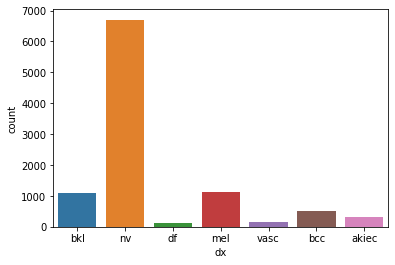

In [8]:
sns.countplot(main_df['dx'])

In [9]:
main_df['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

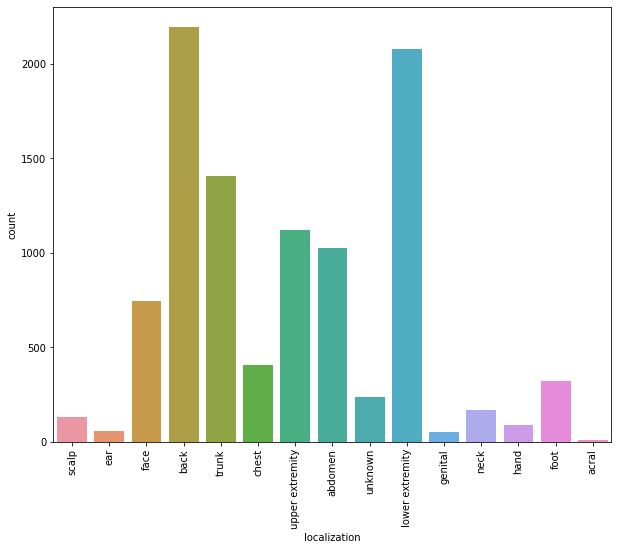

In [10]:
plt.figure(figsize=(10,8))
sns.countplot(main_df['localization'])
plt.xticks(rotation=90)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


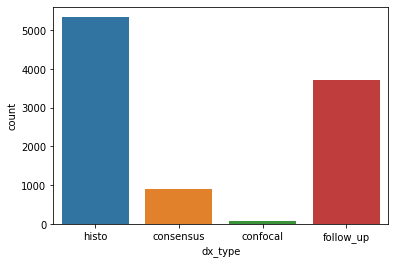

In [11]:
sns.countplot(main_df['dx_type'])

In [12]:
main_df['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [13]:
main_df.isna().sum().sort_values(ascending=False)

age             57
localization     0
sex              0
dx_type          0
dx               0
image_id         0
lesion_id        0
dtype: int64

In [14]:
print(main_df['age'].mean())
print(main_df['age'].median())
main_df['age'].fillna(main_df['age'].mean(),inplace=True)

51.863828077927295
50.0


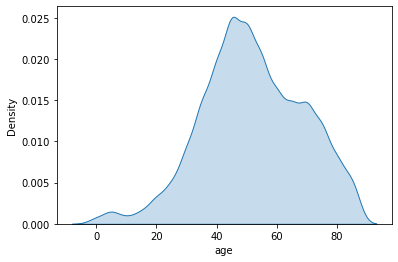

In [15]:
sns.kdeplot(main_df['age'],shade=True)

In [16]:
main_df['sex'].value_counts()

male       5406
female     4552
unknown      57
Name: sex, dtype: int64

In [17]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_classes_dict = {
    0:'nv',
    1:'mel',
    2:'bkl',
    3:'bcc',
    4:'akiec',
    5:'vasc',
    6:'df'
}

main_df['cell_type'] = main_df['dx'].map(lesion_type_dict)

In [18]:
main_df['cell_type_idx'] = pd.Categorical(main_df['cell_type']).codes

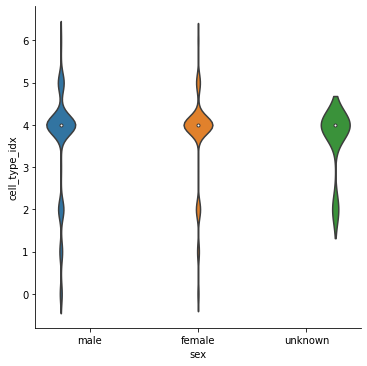

In [19]:
sns.catplot(x="sex", y="cell_type_idx",
                    hue="sex",
                    data=main_df,
                    kind="violin")

In [20]:
import os
#pil_image = os.path.join('images')
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('', '*', '*.jpg'))}

In [21]:
main_df['path'] = main_df['image_id'].map(image_path.get)
main_df.head()

lesion_id  ...                                     path
0  HAM_0000118  ...  HAM10000_images_part_1/ISIC_0027419.jpg
1  HAM_0000118  ...  HAM10000_images_part_1/ISIC_0025030.jpg
2  HAM_0002730  ...  HAM10000_images_part_1/ISIC_0026769.jpg
3  HAM_0002730  ...  HAM10000_images_part_1/ISIC_0025661.jpg
4  HAM_0001466  ...  HAM10000_images_part_2/ISIC_0031633.jpg

[5 rows x 10 columns]

In [22]:
image_example = np.asarray(pil_image.open(main_df['path'][0]))

In [23]:
image_example.shape

(450, 600, 3)

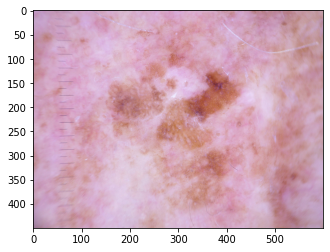

In [24]:
plt.imshow(image_example)

In [25]:
main_df['image'] = main_df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((150,100))))

In [26]:
main_df.head()

lesion_id  ...                                              image
0  HAM_0000118  ...  [[[188, 151, 193], [193, 156, 197], [192, 155,...
1  HAM_0000118  ...  [[[24, 13, 22], [23, 13, 22], [24, 14, 25], [2...
2  HAM_0002730  ...  [[[185, 126, 135], [188, 131, 142], [191, 136,...
3  HAM_0002730  ...  [[[23, 11, 16], [24, 11, 19], [27, 13, 23], [3...
4  HAM_0001466  ...  [[[129, 87, 109], [139, 95, 118], [148, 103, 1...

[5 rows x 11 columns]

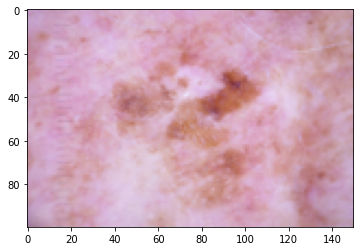

In [27]:
plt.imshow(main_df['image'][0])

In [28]:
main_df['image'][0].shape

(100, 150, 3)

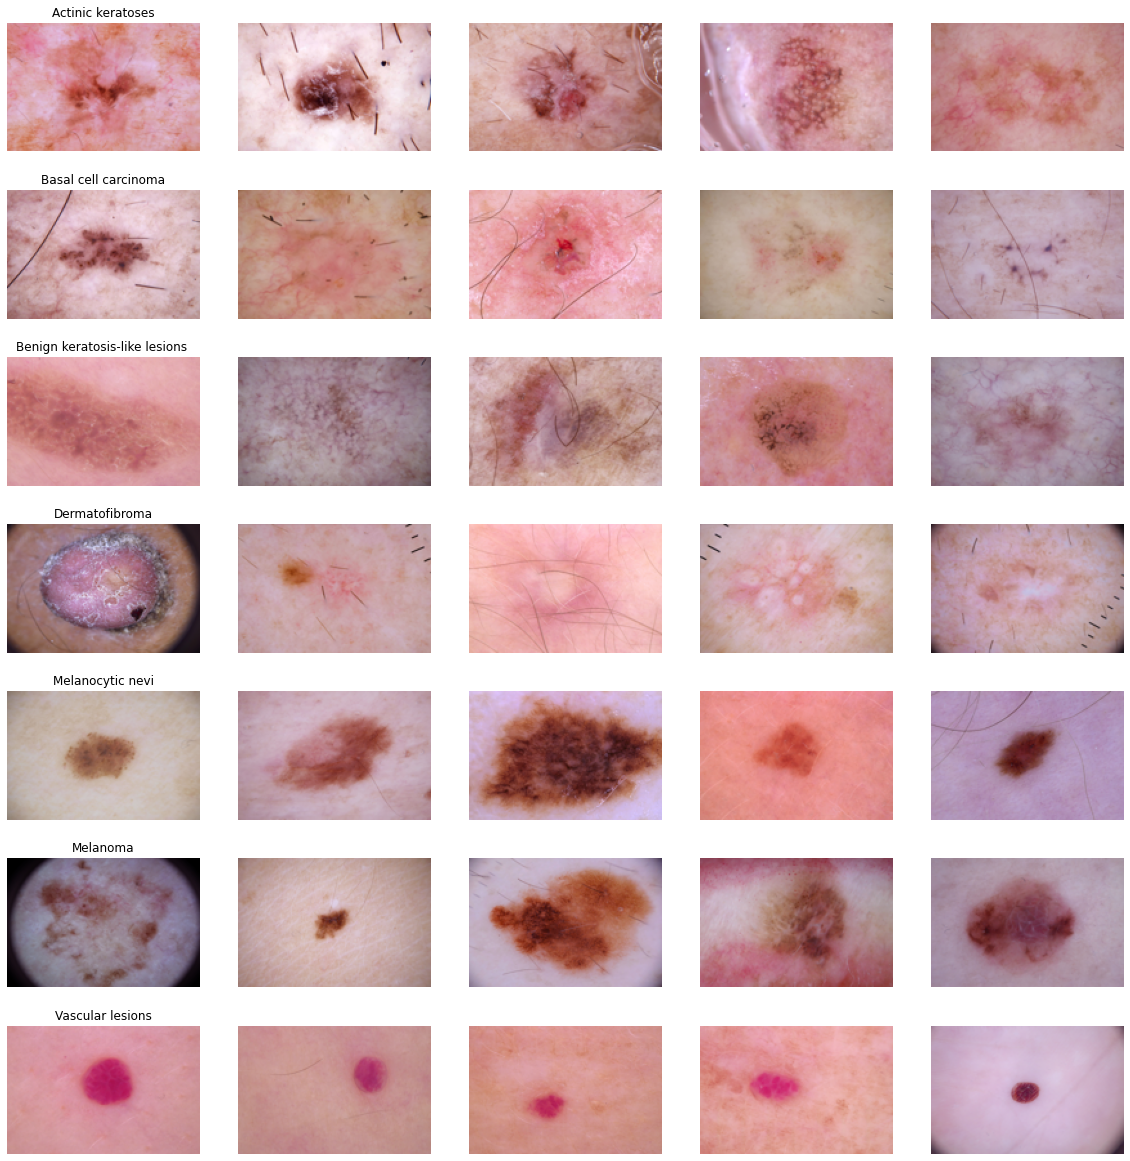

In [29]:
fig,axes = plt.subplots(7,5,figsize=(20,21))
for nth_axis,(cell_type_name,cell_type_row) in zip(axes,main_df.sort_values(['cell_type']).groupby('cell_type')):
    nth_axis[0].set_title(cell_type_name)
    for column_axis,(_,column_row) in zip(nth_axis,cell_type_row.sample(5).iterrows()):
        column_axis.imshow(column_row['image'])  
        column_axis.axis('off')

In [30]:
features = main_df.drop(['cell_type_idx'],axis=1)

target = main_df['cell_type_idx']

X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features,target,test_size=0.01)

In [31]:
x_train = np.asarray(X_TRAIN['image'].tolist())
x_test = np.asarray(X_TEST['image'].tolist())

In [32]:
print(x_train.shape)
print(x_test.shape)

(9914, 100, 150, 3)
(101, 100, 150, 3)


In [33]:
x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train-x_train_mean) / x_train_std
x_test = (x_test-x_test_mean) / x_test_std

In [34]:
print(Y_TRAIN.shape)
print(Y_TEST.shape)

(9914,)
(101,)


In [35]:
y_train = to_categorical(Y_TRAIN,num_classes=7)
y_test = to_categorical(Y_TEST,num_classes=7)

In [36]:
print(y_train.shape)
print(y_test.shape)

(9914, 7)
(101, 7)


In [37]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.15)

In [38]:
X_train  = X_train.reshape(X_train.shape[0],100,150,3)
x_test  = x_test.reshape(x_test.shape[0],100,150,3)
X_val  = X_val.reshape(X_val.shape[0],100,150,3)

In [39]:
print(X_train.shape)
print(x_test.shape)
print(X_val.shape)

(8426, 100, 150, 3)
(101, 100, 150, 3)
(1488, 100, 150, 3)


In [40]:
input_shape = (100, 150, 3)
num_classes = 7
from keras.models import Sequential , Model
from keras.layers import Dropout , GlobalAveragePooling2D
model = MobileNet(weights="imagenet",
include_top=False , input_shape=(100, 150, 3))
x = model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(7, activation='sigmoid')(x)
model = Model(inputs=model.input, outputs=predictions)
model.summary()


17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 150, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 75, 32)        128       
______________________________________________________________

In [41]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [44]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [45]:
epochs = 25
batch_size = 32

history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(X_val,Y_val),
    validation_steps=X_val.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
309/309 [==============================] - 89s 280ms/step - loss: 1.3015 - accuracy: 0.6289 - val_loss: 0.6983 - val_accuracy: 0.7863
Epoch 2/25
309/309 [==============================] - 89s 289ms/step - loss: 0.6688 - accuracy: 0.7667 - val_loss: 0.5868 - val_accuracy: 0.7843
Epoch 3/25
309/309 [==============================] - 88s 284ms/step - loss: 0.5344 - accuracy: 0.8024 - val_loss: 0.5302 - val_accuracy: 0.7829
Epoch 4/25
309/309 [==============================] - 92s 296ms/step - loss: 0.4737 - accuracy: 0.8278 - val_loss: 0.5214 - val_accuracy: 0.8098
Epoch 5/25
309/309 [==============================] - 91s 293ms/step - loss: 0.4394 - accuracy: 0.8401 - val_loss: 0.4812 - val_accuracy: 0.8226
Epoch 6/25
309/309 [==============================] - 90s 291ms/step - loss: 0.4138 - accuracy: 0.8431 - val_loss: 0.4042 - val_accuracy: 0.8636
Epoch 7/25
309/309 [==============================] - 91s 293ms/step - loss: 0.3728 - accuracy: 0.8643 - val_loss: 0.4295 - val_ac

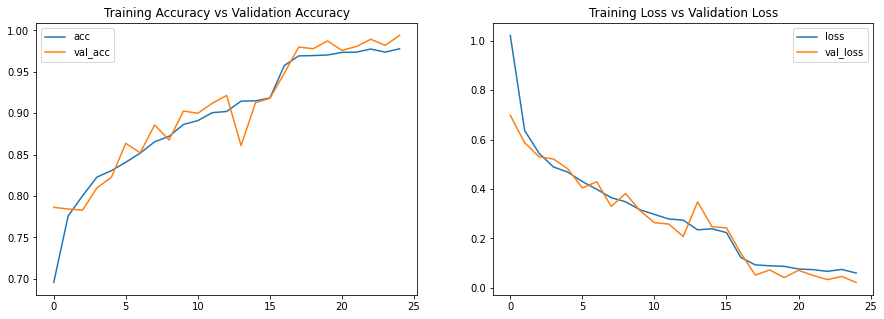

In [46]:
def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="acc")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

In [47]:
print("MAXIMUM ACCURACY OF MOBILENET NETWORK is : ", round(max(model.history.history['val_accuracy'])*100,4))

MAXIMUM ACCURACY OF MOBILENET NETWORK is :  99.3952


In [48]:
!pip install gradio

     |████████████████████████████████| 1.1MB 6.7MB/s 
     |████████████████████████████████| 215kB 27.0MB/s 
     |████████████████████████████████| 3.2MB 24.1MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
     |████████████████████████████████| 962kB 55.7MB/s 
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-cp37-none-any.whl size=3372 sha256=a930b5d34ce1c166ce6e3d234aa7f02f585d2dce237645a4d2be93fa3182b55d
  Stored in directory: /root/.cache/pip/wheels/9f/fc/a7/ab5712c3ace9a8f97276465cc2937316ab8063c1fea488ea77
  Created wheel for ffmpy: filename=ffmpy-0.3.0-cp37-none-any.whl size=4710 sha256=17aacfe42300b748338877efeccfc41570e1f8c9541bd427afac6df894c3f186
  Stored in directory: /root/.cache/pip/wheels/cc/ac/c4/bef572cb7e52bfca170046f567e64858632daf77e0f34e5a74
  Created wheel for Flask-BasicAuth: filename=Flask_BasicAuth-0.2.0-cp37-none-any.whl size=4232 sha256=f9fe8bd8527bfa53772da36474120151ba9bd6e801f3e243ce94e21d293e2c54
  Stored in directory

In [49]:
import gradio as gr

In [52]:
def predict_image(img):
  img_4d=img.reshape(-1,100,150,3)
  prediction=model.predict(img_4d)[0]
  return {lesion_classes_dict[i]: float(prediction[i]) for i in range(7)}

In [54]:
image = gr.inputs.Image(shape=(100,150))
label = gr.outputs.Label(num_top_classes=7)

gr.Interface(fn=predict_image, inputs=image, outputs=label,interpretation='default').launch(debug='True')

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://25423.gradio.app
Interface loading below...


KeyboardInterrupt: ignored